Backward Facing Step Flow (BFS) DEMO code

This notebook demonstrates solving steady-state Backward Facing Step Flow (BFS) using DeepFlow. The BFS flow is a common benchmark problem in fluid dynamics, where the flow separates and reattaches after encountering a step.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle_pde = df.geometry.rectangle([0,5], [0,1])
rectange_ic = df.geometry.rectangle([0,5], [0,1])

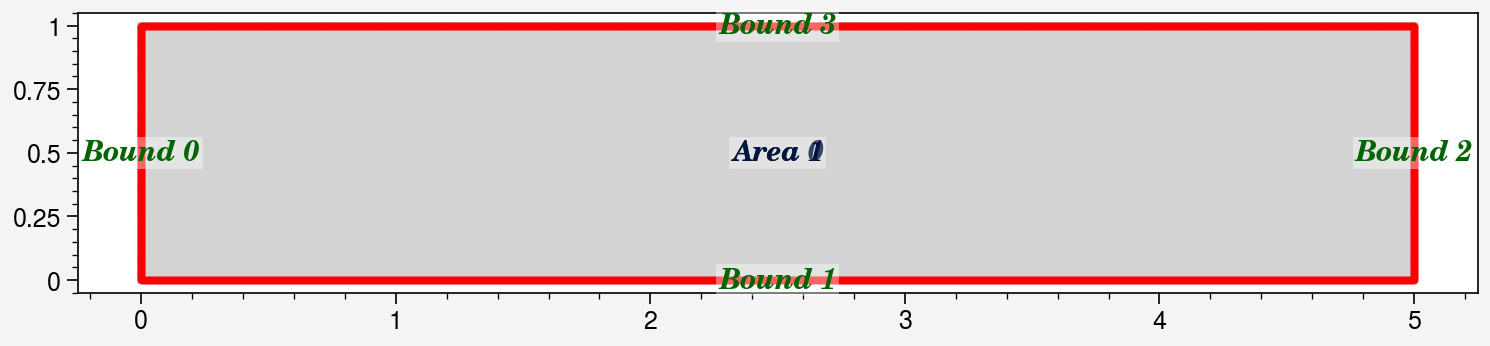

In [3]:
domain = df.domain(rectangle_pde, rectange_ic.area_list)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\deepflow\src\deepflow\physicsinformed.py:122: UserWarning: expo_scaling has not yet defined. False is set as default.
  warnings.warn("expo_scaling has not yet defined. False is set as default.")


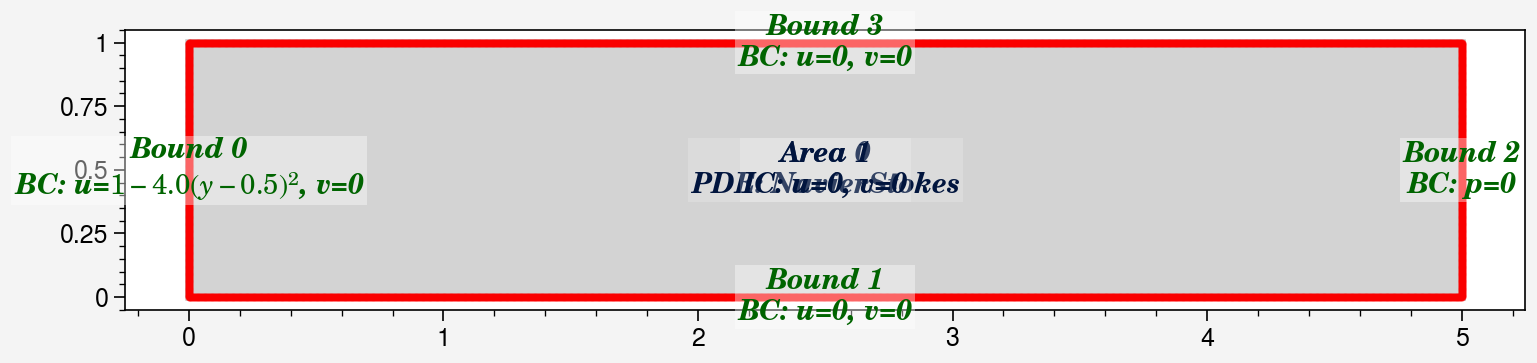

In [4]:
domain.bound_list[0].define_bc({'u': df.parabolic('y', 1,1,0.5),'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.001, L=1, mu=0.001, rho=1000))
domain.area_list[1].define_ic({'u': 0,'v': 0})

for geom in domain:
    geom.define_time([0, 10], 'random')

domain.show_setup()


Sample initial points for training.

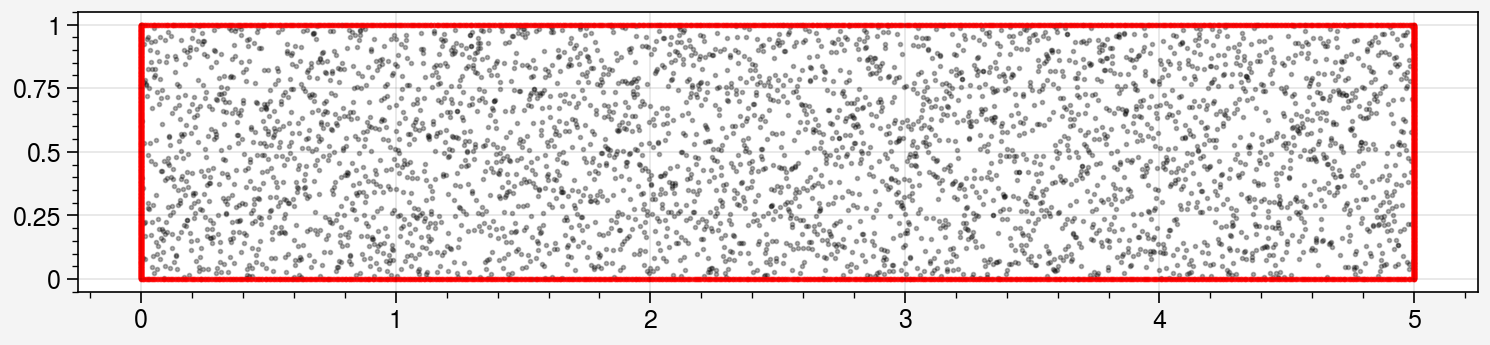

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000, 2000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000, 2000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [7]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y','t'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.001,
    epochs=1000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.91400, bc_loss: 0.86594, pde_loss: 0.00009, ic_loss: 0.04798
Epoch: 200, total_loss: 0.15948, bc_loss: 0.13487, pde_loss: 0.02015, ic_loss: 0.00446
Epoch: 400, total_loss: 0.03458, bc_loss: 0.01444, pde_loss: 0.01070, ic_loss: 0.00945
Epoch: 600, total_loss: 0.02541, bc_loss: 0.01232, pde_loss: 0.00730, ic_loss: 0.00580
Epoch: 800, total_loss: 0.02111, bc_loss: 0.01105, pde_loss: 0.00541, ic_loss: 0.00465
Epoch: 1000, total_loss: 0.01774, bc_loss: 0.00972, pde_loss: 0.00420, ic_loss: 0.00383
Epoch: 1000, total_loss: 0.01774, bc_loss: 0.00972, pde_loss: 0.00420, ic_loss: 0.00383


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=350,
    threshold_loss=0.0001,
    do_between_epochs=do_in_lbfgs)

Epoch: 970, total_loss: 0.01532, bc_loss: 0.00655, pde_loss: 0.00497, ic_loss: 0.00379
Epoch: 1020, total_loss: 0.00327, bc_loss: 0.00056, pde_loss: 0.00224, ic_loss: 0.00047
Epoch: 1070, total_loss: 0.00192, bc_loss: 0.00034, pde_loss: 0.00129, ic_loss: 0.00028
number of bound : ['0: 1296', '1: 1404', '2: 1442', '3: 1286']
number of area : ['0: 2529', '1: 2622']
Epoch: 1120, total_loss: 0.00205, bc_loss: 0.00038, pde_loss: 0.00143, ic_loss: 0.00024
Epoch: 1170, total_loss: 0.00119, bc_loss: 0.00020, pde_loss: 0.00084, ic_loss: 0.00015
number of bound : ['0: 1605', '1: 1724', '2: 1870', '3: 1579']
number of area : ['0: 3057', '1: 3367']
Epoch: 1220, total_loss: 0.00146, bc_loss: 0.00027, pde_loss: 0.00109, ic_loss: 0.00010
Epoch: 1270, total_loss: 0.00080, bc_loss: 0.00017, pde_loss: 0.00058, ic_loss: 0.00005
number of bound : ['0: 1886', '1: 2110', '2: 2258', '3: 1964']
number of area : ['0: 3618', '1: 4054']
Epoch: 1319, total_loss: 0.00086, bc_loss: 0.00020, pde_loss: 0.00059, ic_lo

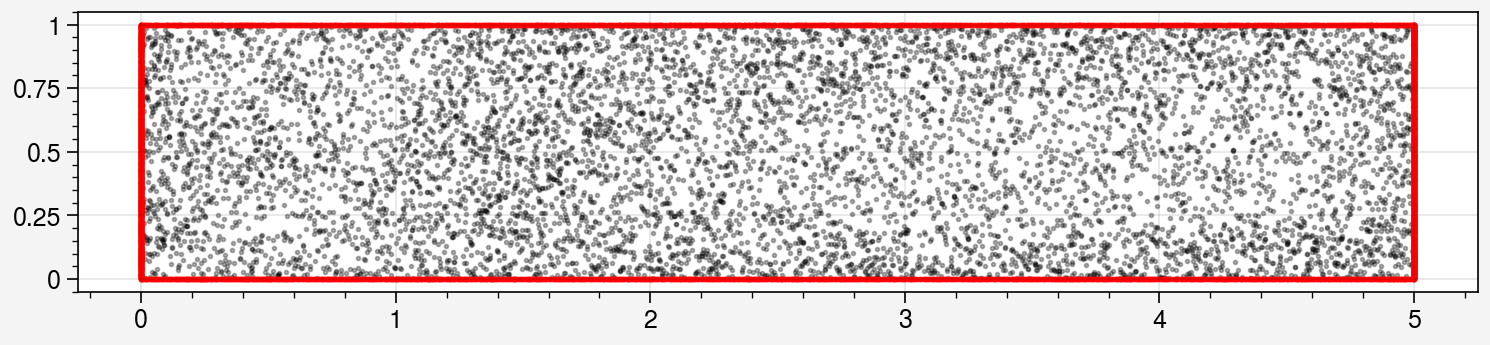

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle("model.pkl")
model2 = df.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [30]:
df.Visualizer.refwidth_default = 6

In [31]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([400, 80])
# Show available data's key
area_eval.define_time(10)
print(area_eval)

Available data keys: ('u', 'v', 'p', 'pde_residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 't', 'total_loss', 'bc_loss', 'pde_loss', 'ic_loss')


In [32]:
area_eval['v_mag'] = (area_eval['u']**2 + area_eval['v']**2)**0.5

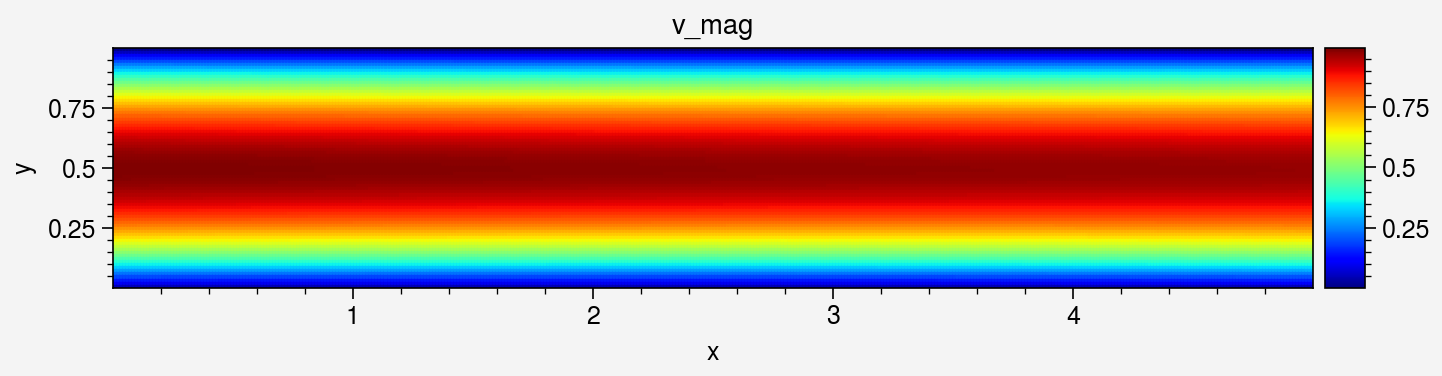

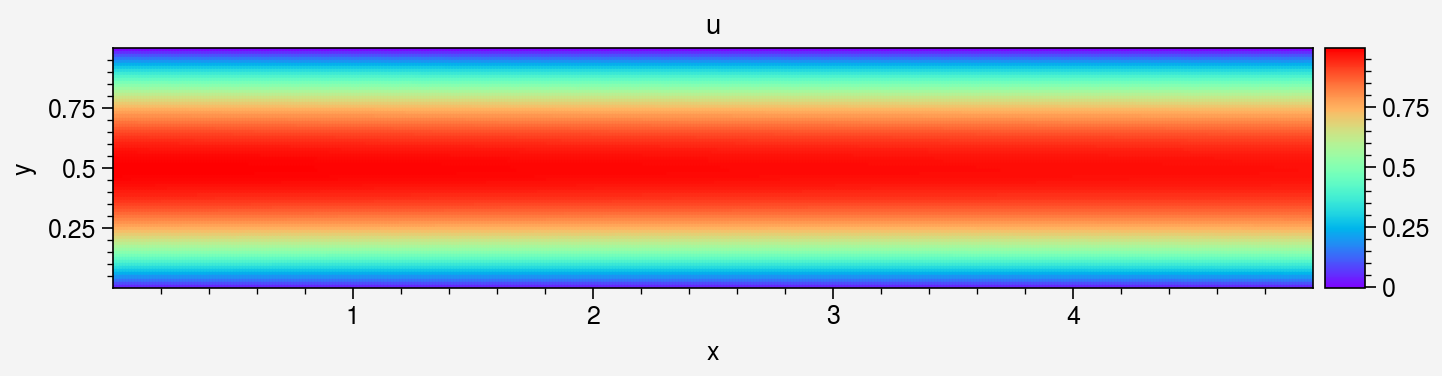

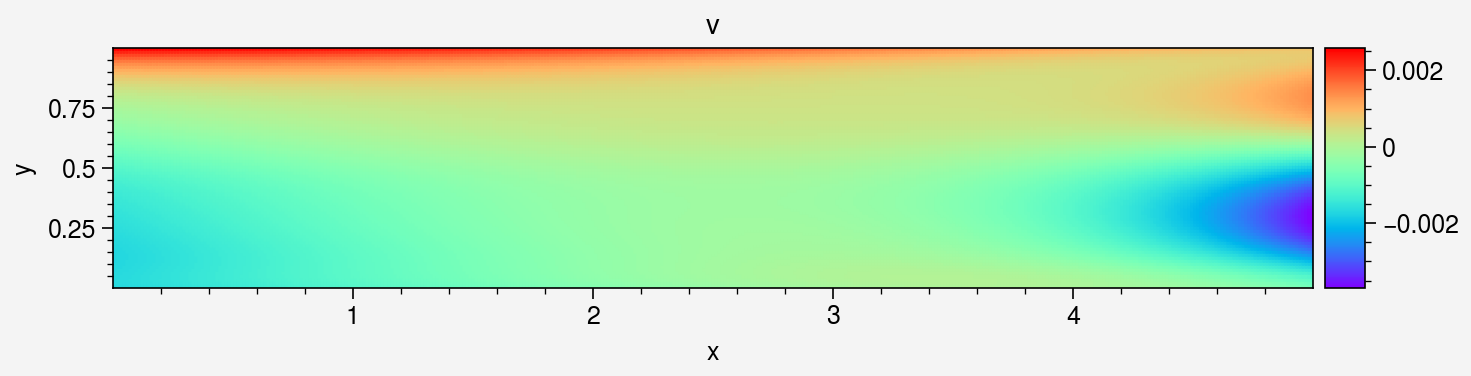

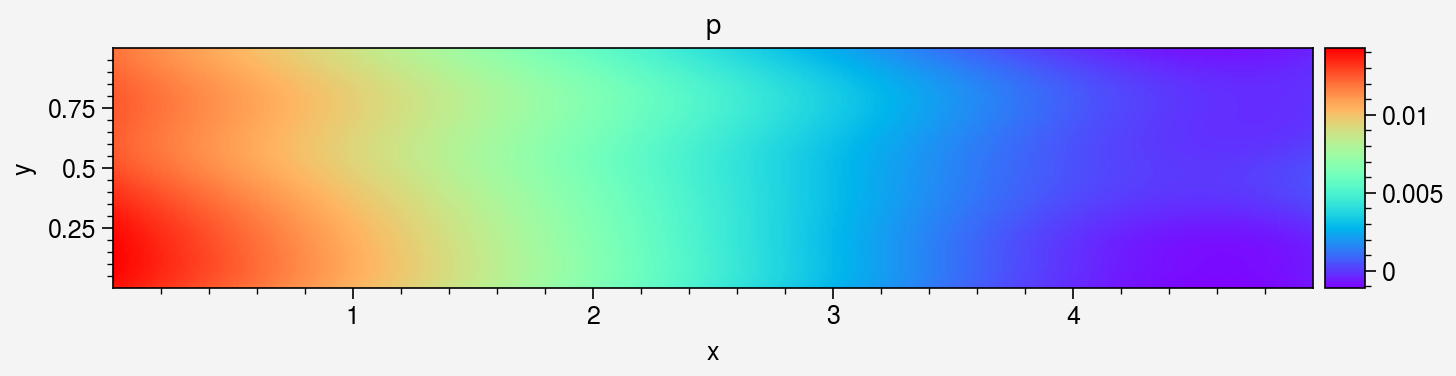

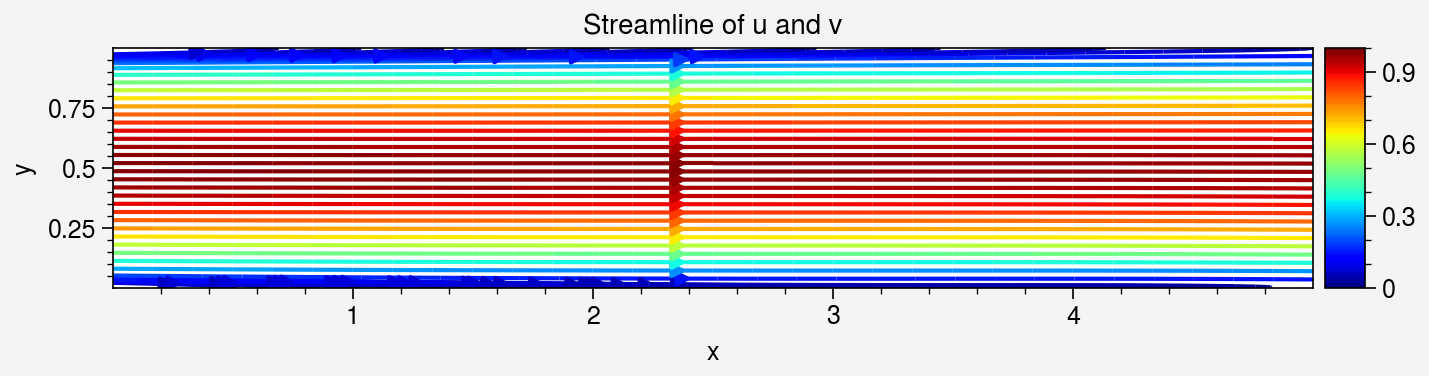

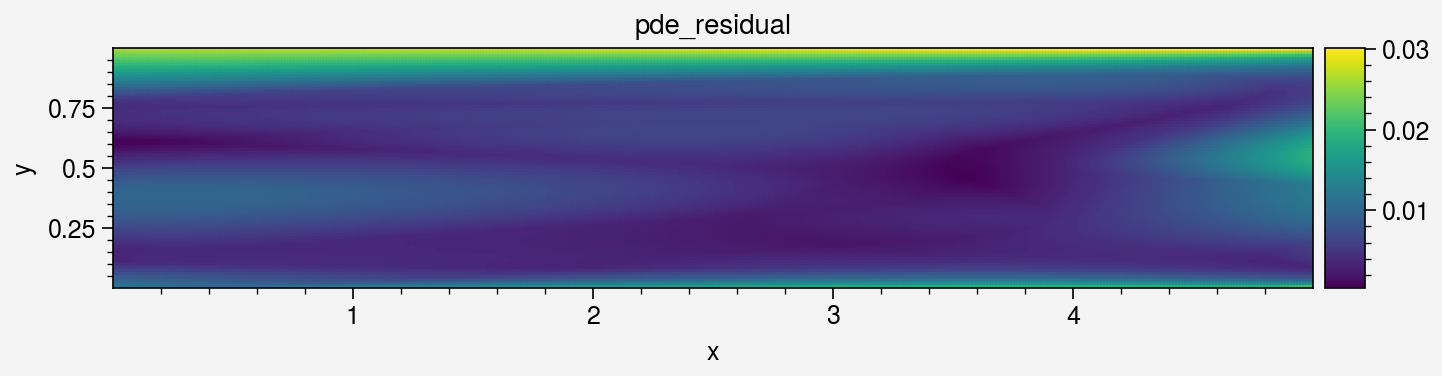

In [33]:
_ = area_eval.plot_color('v_mag', s=2, cmap='jet').savefig("colorplot_v_mag.png")
_ = area_eval.plot_color('u', s=2, cmap='rainbow')
_ = area_eval.plot_color('v', s=2, cmap='rainbow')
_ = area_eval.plot_color('p', s=2, cmap='rainbow')
_ = area_eval.plot_streamline('u', 'v', cmap = 'jet')
_ = area_eval.plot_color('pde_residual', s=2, cmap='viridis')

## 4.2 Animate Area 

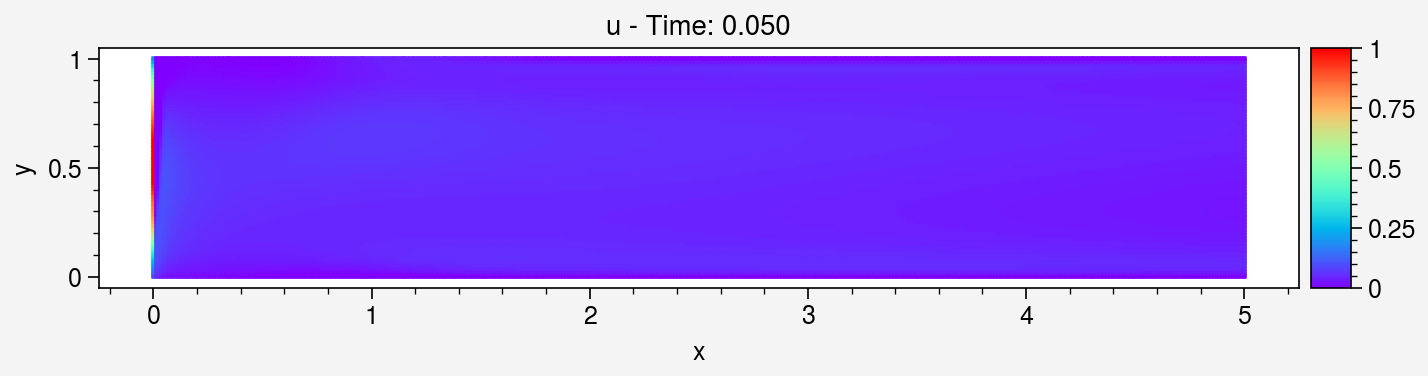

In [35]:
anim = area_eval.plot_animate('u', range_t=[0.05, 8.1], dt = 0.1, frame_interval=100, cmap = 'rainbow', s=1, color_range=[0,1])
anim.save("animation.gif")

## 4.3 Visualize Neural Network data

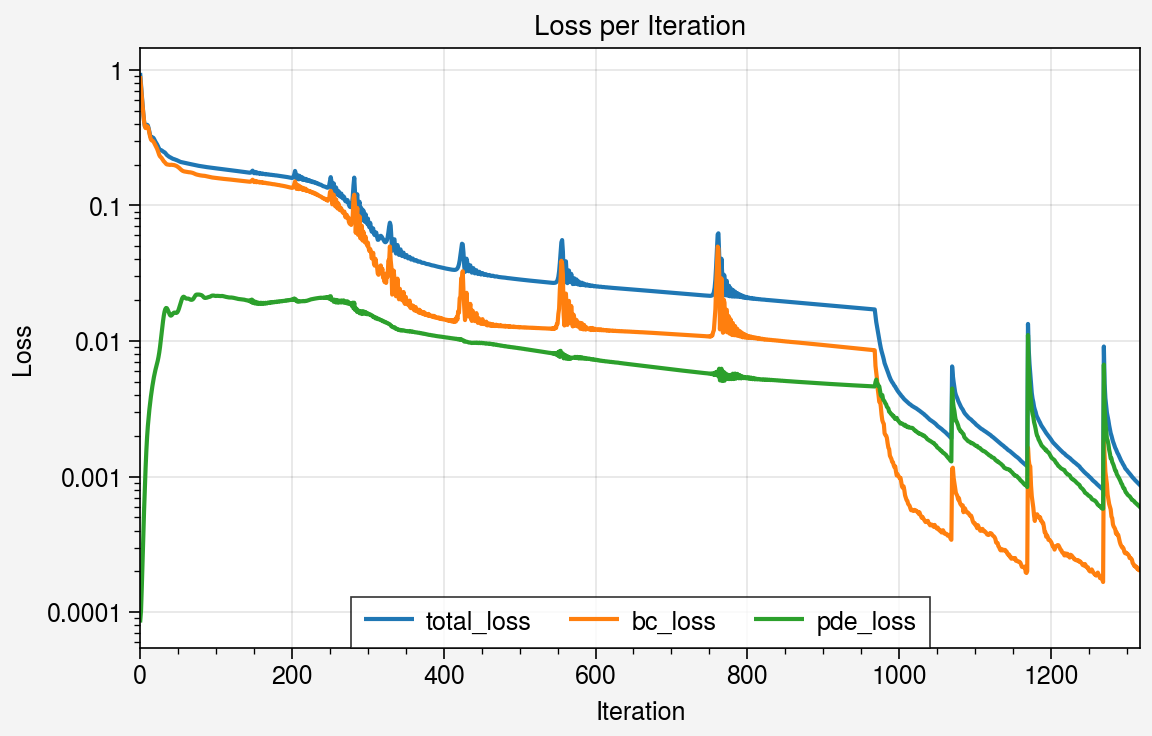

In [18]:
_ = area_eval.plot_loss_curve(log_scale=True)

### 4.4 Export data

In [19]:
# store the x,y,velocity_magnitude data
x_data = area_eval.data_dict['x']
y_data = area_eval.data_dict['y']
u_data = area_eval.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)